## **프로젝트 : 단어 Level로 번역기 업그레이드하기**
* 데이터에서 상위 33,000개의 샘플만 사용해주세요.
* 33000개 중 3000개는 테스트 데이터로 분리하여 모델을 학습한 후에 번역을 테스트 하는 용도로 사용합니다.

In [1]:
# 필요한 라이브러리 import
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [2]:
# 데이터프레임으로 읽어오기
file_path = 'C:/Users/Minjoo Lee/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) # 샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
144340,I thought they wouldn't like you.,Je pensais qu'elles ne t'apprécieraient pas.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
187372,She was asked not to speak at the meeting.,On lui demanda de ne pas parler à la réunion.,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
123258,I'm the middle child of three.,Je suis le second de trois enfants.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
32070,I bet you're right.,Je parie que vous avez raison.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
158611,This is the woman I told you about.,C'est la femme dont je t'ai parlé.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


세번째 열은 불필요하므로 제거하고, 훈련 데이터는 33,000개의 샘플로 줄이겠다.

In [3]:
lines = lines[['eng', 'fra']][:33000] # 33000개 샘플 사용
lines.sample(5)

,eng,fra
28552,They're not alone.,Elles ne sont pas seules.
13201,We have a deal.,Nous avons un accord.
11876,It's beyond me.,Ça me dépasse.
16908,They caught Tom.,Ils ont attrapé Tom.
31251,Don't play with me.,Ne joue pas avec moi.


### **Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)**
1. 구두점(Punctuation)을 단어와 분리해주세요.
2. 소문자로 바꿔주세요.
3. 띄어쓰기 단위로 토큰화를 수행하세요.

In [4]:
# 데이터 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 소문자로 변환하고 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 구두점 앞뒤에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백을 하나의 공백으로 대체
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 알파벳이나 구두점이 아닌 문자는 공백으로 변환
    sentence = sentence.split() # 공백을 기준으로 분리
    
    return sentence

In [5]:
# 전처리 수행
lines['eng'] = lines['eng'].apply(preprocess_sentence)
lines['fra'] = lines['fra'].apply(preprocess_sentence)

In [6]:
# 전처리된 데이터 출력
lines.sample(5)

,eng,fra
21786,"[she, disliked, him, .]","[elle, prouvait, pour, lui, une, aversion, .]"
31067,"[do, you, have, a, copy, ?]","[en, as, tu, une, copie, ?]"
24648,"[could, you, help, us, ?]","[pourriez, vous, nous, aider, ?]"
23785,"[you, abandoned, me, .]","[vous, m, avez, abandonn, e, .]"
13752,"[you, re, popular, .]","[vous, tes, populaire, .]"


### **Step 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣어주세요.**

seq2seq 동작을 위해서 디코더의 입력과 예측에는 시작 토큰 `<sos>`와 종료 토큰 `<eos>`가 필요하다. 

In [7]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines['fra'] = lines['fra'].apply(lambda x: [sos_token] + x + [eos_token])
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
23015,"[trust, me, on, that, .]","[\t, crois, en, moi, !, \n]"
14089,"[close, your, eyes, .]","[\t, ferme, les, yeux, ., \n]"
12946,"[tom, likes, that, .]","[\t, tom, aime, a, ., \n]"
9008,"[that, s, unreal, .]","[\t, c, est, incroyable, ., \n]"
15140,"[i, lost, the, game, .]","[\t, j, ai, perdu, le, match, ., \n]"


### **Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.**

영어와 프랑스어는 사용하는 언어가 다르므로 단어장을 별도로 만들어준다.

In [8]:
# 영어 문장에 대한 정수 인코딩
eng_tokenizer = Tokenizer(char_level=False) # 문자 단위로 Tokenizer를 생성
eng_tokenizer.fit_on_texts(lines.eng) # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng) # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[27, 1], [27, 1], [27, 1]]

In [9]:
# 프랑스어 문장에 대한 정수 인코딩
fra_tokenizer = Tokenizer(char_level=False) # 문자 단위로 Tokenizer를 생성 
fra_tokenizer.fit_on_texts(lines.fra) # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra) # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 73, 9, 2], [1, 341, 3, 2], [1, 27, 524, 9, 2]]

다음과 같이 단어장의 크기를 변수로 저장하고, 0번 토큰을 고려하여 단어장 크기에 1을 더해 변수에 저장한다.

In [10]:
# 단어장의 크기
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4515
프랑스어 단어장의 크기 : 7264


영어 데이터와 프랑스어 데이터의 최대 길이를 각각 구해서 패딩(`<pad>`)을 위한 작업을 수행한다.  
이를 통해 모델의 입력 시퀀스 길이를 일정하게 맞추고, 남는 부분을 패딩으로 채울 수 있다.

In [11]:
# 데이터의 최대 길이
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [12]:
# 전체 통계 정보
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4515
프랑스어 단어장의 크기 : 7264
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


#### **teacher forcing**

프랑스어 시퀀스는 두 가지 버전으로 준비해야 한다.  
하나는 디코더의 출력과 비교할 정답 데이터로 사용할 버전이고, 다른 하나는 디코더의 입력으로 사용할 버전이다.

In [13]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [14]:
# 디코더의 입력과 출력을 각각 출력
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 73, 9], [1, 341, 3], [1, 27, 524, 9]]
[[73, 9, 2], [341, 3, 2], [27, 524, 9, 2]]


디코더의 입력의 경우에는 숫자 2(`<eos>` 토큰)가 제거되었고, 디코더의 출력의 경우에는 숫자 1(`<sos>` 토큰)이 제거된 것을 확인할 수 있다.

#### **padding**

In [15]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


모든 샘플들의 길이가 동일하게 변환된 것을 알 수 있다. 

In [16]:
print(encoder_input[0])

[27  1  0  0  0  0  0  0]


정해준 길이보다 짧은 데이터들은 뒤에 0(`<pad>`)으로 채워진 것을 확인할 수 있다.

#### **train test split**

생성한 데이터 33000건 중 3000건은 테스트 데이터로 삼고, 나머지를 학습 데이터로 삼기로 했다.  

먼저 데이터를 분리하기 전에 데이터를 섞어주자.

In [17]:
# 데이터 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [18]:
n_of_val = 3000

# 학습 데이터와 검증 데이터로 나누기
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 8)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 17)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 17)


### **Step 4. 임베딩 층(Embedding layer) 사용하기**

#### **encoder**

In [19]:
embedding_size = 256
hidden_size = 256

# 인코더에서 사용할 임베딩 층
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(eng_vocab_size, embedding_size)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout = 0.5, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

#### **decoder**

In [20]:
# 디코더에서 사용할 임베딩 층
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout = 0.5, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state=encoder_states)

In [21]:
# 소프트맥스 층 추가
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

### **Step 5. 모델 구현하기**

In [22]:
# 모델 구성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1155840     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    1859584     ['input_2[0][0]']                
                                                                                              

In [23]:
# 모델 컴파일
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",  metrics=['acc'])

In [ ]:
# 모델 학습
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=40)

Epoch 1/40
235/235 [==============================] - 13s 29ms/step - loss: 1.8389 - acc: 0.7176 - val_loss: 1.4395 - val_acc: 0.7625
Epoch 2/40
235/235 [==============================] - 5s 20ms/step - loss: 1.3307 - acc: 0.7799 - val_loss: 1.2300 - val_acc: 0.7982
Epoch 3/40
235/235 [==============================] - 5s 21ms/step - loss: 1.1560 - acc: 0.8072 - val_loss: 1.1106 - val_acc: 0.8165
Epoch 4/40
235/235 [==============================] - 5s 21ms/step - loss: 1.0512 - acc: 0.8216 - val_loss: 1.0392 - val_acc: 0.8284
Epoch 5/40
235/235 [==============================] - ETA: 0s - loss: 0.9755 - acc: 0.8316

In [ ]:
# 손실과 정확도의 변화 시각화
history_dict = model.history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
accuracy = history_dict['acc']
val_accuracy = history_dict['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### **Step 6. 모델 평가하기**

In [ ]:
# 인코더 정의
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

seq2seq는 훈련할 때와 테스트 단계의 동작이 다르다.  
이를 위해서 테스트 단계의 디코더 모델은 설계를 다시 해줄 필요가 있다. 

In [ ]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_size,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# 임베딩 층 추가
dec_emb_eval = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
# decoder_states_inputs를 현재 time step의 초기 상태로 사용
# 구체적인 동작 자체는 def decode_sequence()에 구현
decoder_outputs_eval, state_h_eval, state_c_eval = decoder_lstm(dec_emb_eval, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_eval = [state_h_eval, state_c_eval]

In [ ]:
# 디코더의 출력층 재설계
decoder_outputs_eval = decoder_softmax_layer(decoder_outputs_eval)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs_eval] + decoder_states_eval)
decoder_model.summary()

In [ ]:
# 단어에서 정수로, 정수에서 단어로 바꾸는 사전(dictionary) 준비
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [ ]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['\t']) and i!=fra2idx['\n']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [ ]:
# 변역 결과 확인
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print('입력 문장:', seq_to_src(encoder_input_test[seq_index]))
    print('정답 문장:', seq_to_tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])
    print("-"*50)

---

### **프로젝트 회고**

#### **새로 알게 된 것!**
* Seq2Seq(Sequence-to-Sequence): 시퀀스를 다른 시퀀스로 변환하는 모델 구조
* 조건적 언어모델(Conditional Language Model): 특정 조건을 고려하여 문장을 생성하는 모델
* 교사 강요(teacher forcing): 학습 시에 디코더의 입력으로 정답 시퀀스를 사용하는 것

**기계 번역의 역사**
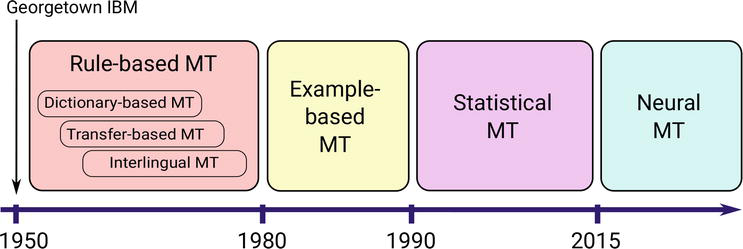

* 규칙 기반의 기계 번역(Rule-based Machine Translation): 전에 정의된 규칙과 패턴을 사용하여 번역을 수행하는 방법
* 통계적 기계 번역(Statistical Machine Translation): 대규모 병렬 말뭉치를 기반으로 통계 모델을 학습하여 번역을 수행하는 방
* 신경망 기계 번역(Neural Machine Translation, NMT): 인공신경망 모델을 사용하여 문장을 번역하는 방법으로 이때 사용된 인공 신경망이 seq2seq

**다양한 RNN의 활용 방법**
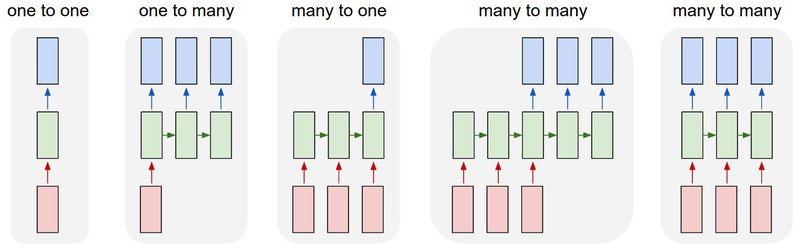
1. One-to-One: 하나의 입력에 대해 하나의 출력을 반환하는 가장 기본적인 RNN 구조
2. One-to-Many: 하나의 입력에 대해 여러 개의 출력을 반환하는 구조로, 이미지 캡셔닝과 같은 작업에 활용
3. Many-to-One: 여러 개의 입력에 대해 하나의 출력을 반환하는 구조로, 감성 분석이나 문장 분류에 사용
4. Many-to-Many(동일한 길이의 입력 및 출력): 입력과 출력의 길이가 동일하며, 각 시점에서 입력과 출력이 일치하는 구조로, 감성 분류나 단어 시퀀스의 레이블링에 사용
5. Many-to-Many (다른 길이의 입력 및 출력): 입력과 출력의 길이가 서로 다를 수 있으며, 기계 번역이나 음성 인식과 같은 작업에 활용

**seq2seq의 인코더-디코더 구조**
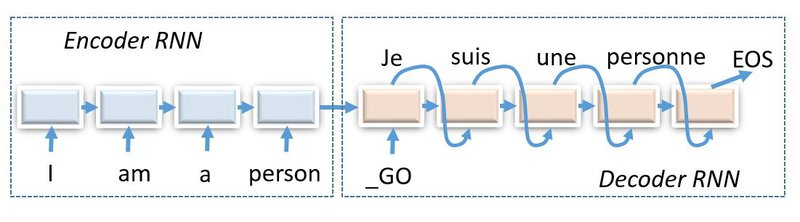
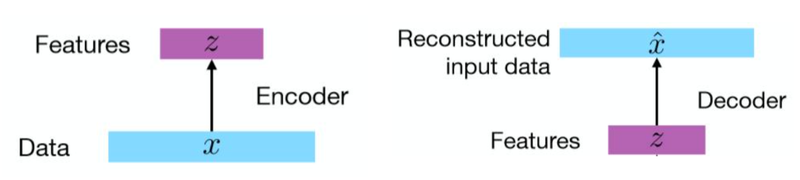

seq2seq 모델은 인코더와 디코더로 구성되어 있으며, 인코더는 입력 문장을 피처 벡터로 변환하고, 디코더는 피처 벡터를 활용하여 출력 문장을 생성한다.

**참고한 레퍼런스**
<br>Tab-delimited Bilingual Sentence Pairs https://www.manythings.org/anki/
<br>A ten-minute introduction to sequence-to-sequence learning https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
<br>정수 인코딩(Integer Encoding) https://wikidocs.net/31766
<br>사전 훈련된 워드 임베딩(Pre-trained Word Embedding) https://wikidocs.net/33793
<br>Word-Level 번역기 만들기(Neural Machine Translation (seq2seq) Tutorial) https://wikidocs.net/86900